# A/B-теститование гипотез

**Цель:** увеличение выручки интернет-магазина

**Задачи:**
- изучить данные (описание гипотез, инофрмация о заказах, информация о пользователях);
- приоритизировать собранные гипотезы;
- запустить A/B-тест;
- проанализировать результаты

## Содержание

1. [Изучение и подготовка данных к анализу](#1id)
2. [Приоритизация гипотез](#2id)
3. [Анализ A/B-теста](#3id)
    * [График кумулятивной выручки по группам](#3.1id)
    * [График кумулятивного среднего чека по группам](#3.2id)
    * [График относительного изменения кумулятивного среднего чека группы B к группе A](#3.3id)
    * [График кумулятивной конверсии по группам](#3.4id)
    * [График относительного изменения кумулятивной конверсии группы B к группе A](#3.5id)
    * [Точечный график количества заказов по пользователям](#3.6id)
    * [Расчет 95-го и 99-го перцентилей количества заказов на пользователя](#3.7id)
    * [Точечный график стоимостей заказов](#3.8id)
    * [Расчет 95-го и 99-го перцентилей стоимости заказов](#3.9id)
    * [Расчет статистической значимости различий в конверсии между группами по «сырым» данным](#3.10id)
    * [Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным](#3.11id)
    * [Расчет статистической значимости различий в конверсии между группами по «очищенным» данным](#3.12id)
    * [Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным](#3.13id)
4. [Решение по результатам теста](#4id)
5. [Вывод](#5id)

## Изучение и подготовка данных к анализу <a id="1id"></a>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import datetime as dt
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Таблица "hypothesis"

In [2]:
try:
    hypothesis = pd.read_csv('/home/olga/Downloads/hypothesis.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')

- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [3]:
# Сброс ограничений на количество символов в записи

pd.set_option('display.max_colwidth', None)

In [4]:
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


### Таблица "orders"

In [5]:
try:
    orders = pd.read_csv('/home/olga/Downloads/orders.csv')
except:
    orders = pd.read_csv('/datasets/orders.csv')

- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

In [6]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Проверим, могли ли попасть одни и те же пользователи в обе группы:

In [8]:
orders.groupby('visitorId').agg({'group':'nunique'}).query('group > 1').count()

group    58
dtype: int64

58 пользователей попали в обе группы. Так как это противоречит правилам проведения A/B-теста, то просто удалим эти 58 задублированных пользователей, чтобы они не попали ни в одну группу.

In [9]:
duplicated_visitors = orders.groupby('visitorId').agg({'group':'nunique'}).query('group > 1').reset_index()

orders = orders[orders['visitorId'].isin(duplicated_visitors['visitorId']) == False]

In [10]:
# проверим, что дубликаты удалились

orders.groupby('visitorId').agg({'group':'nunique'}).query('group > 1').count()

group    0
dtype: int64

In [11]:
print(orders['date'].min())
print(orders['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


### Таблица "visitors"

In [12]:
try:
    visitors = pd.read_csv('/home/olga/Downloads/visitors.csv')
except:
    visitors = pd.read_csv('/datasets/visitors.csv')

- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

In [13]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [14]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [15]:
visitors['group'].value_counts()

A    31
B    31
Name: group, dtype: int64

Проверим датафреймы на дубликаты

In [16]:
visitors.duplicated().sum()

0

In [17]:
orders.duplicated().sum()

0

In [18]:
hypothesis.duplicated().sum()

0

In [19]:
print(visitors['date'].min())
print(visitors['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


**Вывод**

При изучении данных мы поменяли тип данных столбцов 'date' на datetime во всех таблицах.
В таблице "orders" обнаружили пользователей, которые попали в обе группы, что протеворечит правилам A/B-теста. Поэтому было принято решение избавиться от этих пользователей, чтобы результаты были более объективными.
Пропущенных значений и других дубликатов в таблицах нет. Данные готовы к анализу.

## Приоритизация гипотез <a id="2id"></a>

В файле "hypothesis.csv" девять гипотез. Применим фрейворки ICE и RICE, чтобы их приоритизировать. Отсортируем их по убыванию приоритета.

In [20]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


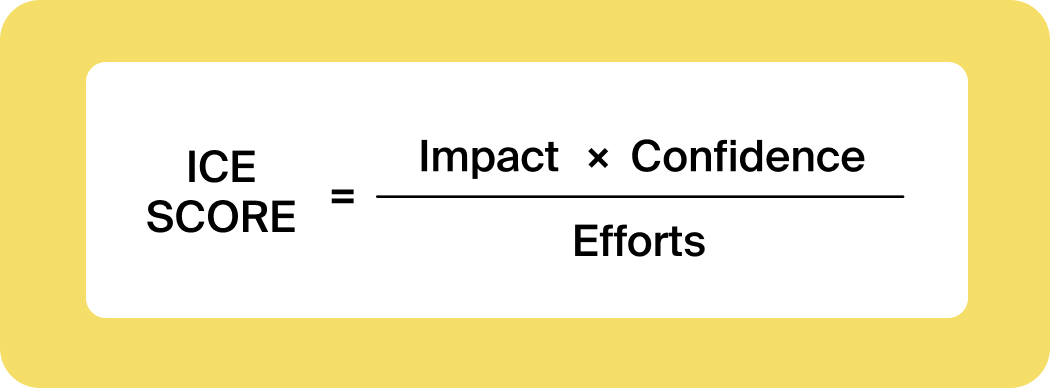

In [21]:
# применение фреймворка ICE

hypothesis['ICE'] = ((hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts'])
hypothesis[['Hypothesis', 'ICE', 'Impact']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE,Impact
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,9
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,10
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,7
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,3
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,3
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,5
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,3
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,1


Наиболее перспективные гипотезы под индексами 8,0,7,6 по ICE: 
- запустить акцию в день рождения
- добавить два новых канала привлечения трафика
- добавить форму подписки
- показ актуальных акций на главной странице

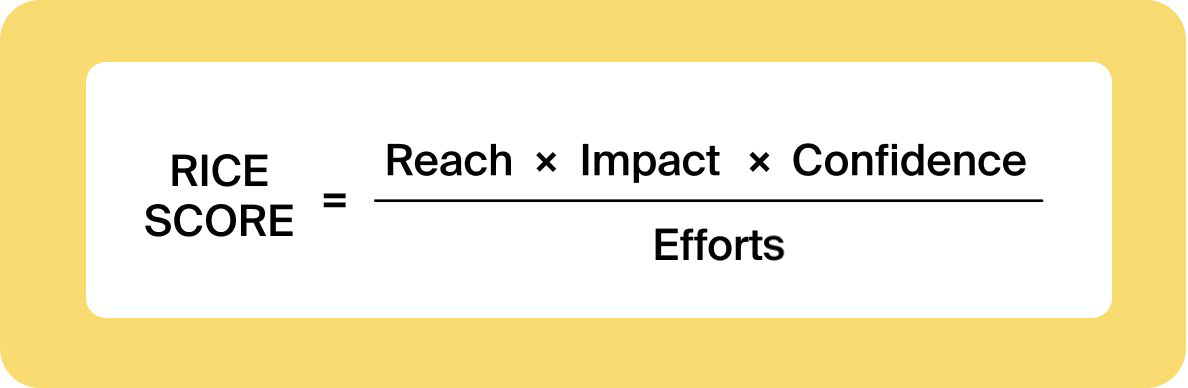

In [22]:
# применение фреймворка RICE

hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']

hypothesis[['Hypothesis', 'RICE', 'Reach']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE,Reach
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0,8
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0,5
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,1
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0,8
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0,2
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0,3
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0,3


Наиболее перспективные гипотезы под индексами 7,2,0,6 по RICE:
- добавить форму подписки;
- добавить блоки рекомендаций товаров;
- добавить два новых канала привлечения трафика;
- показ актуальных акций на главной странице

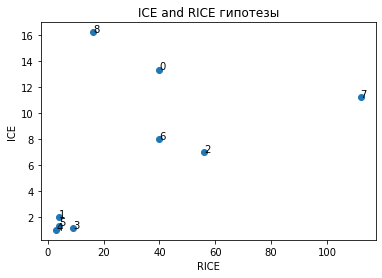

In [23]:
# создадим график для наглядности

y = hypothesis['ICE'] 
z = hypothesis['RICE'] 
n = hypothesis.index 

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

plt.title("ICE and RICE гипотезы") 
plt.xlabel("RICE") 
plt.ylabel("ICE");

Приоритезация гипотез при применении RICE изменилась: на первое место встала гипотзе о добавлении формы подписки. Это произошло, так как параметр охвата у нее наибольший по сравнению с другими гипотезами.

**Приоритетными можем считать следующие гипотезы:**
- `Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`;
- `Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей`

## Анализ A/B-теста <a id="3id"></a>

### 1. Построим график кумулятивной выручки по группам <a id="3.1id"></a>

Соберём агрегированные кумулятивные по дням данные о заказах в несколько действий:
- агрегируем значения;
- вычисли максимальную дату;
- рассчитаем максимум для группы;
- найдем число уникальных транзакций и посетителей;
- применим методы к каждой строке датафрейма;
- отсортируем результаты по столбцам 'date' и 'group'

In [24]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

In [25]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

In [26]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [27]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [28]:
print(cumulativeData['date'].min())
print(cumulativeData['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


Датафрейм cumulativeData создан корректно. Минимальная и максимальная даты совпадают с данными в исходных данных.

Построим графики кумулятивной выручки по дням и группам A/B-тестирования: 

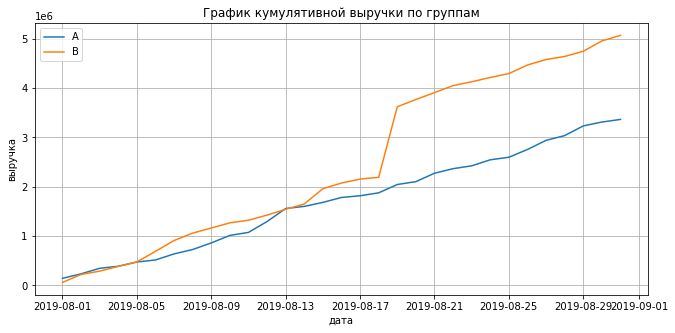

In [29]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(11,5))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xlabel('дата')
plt.ylabel('выручка')
plt.grid()
plt.title('График кумулятивной выручки по группам')

plt.legend();

Выручка растет на протяжении всего теста достаточно равномерно. У группы B заметен резкий скачок примерно с 18 августа. Возможно, это свидетельствует о временном всплеске заказов или покупках дорогостоящих товаров. Стоит проанализировать этот выброс.

### 2. Построим график кумулятивного среднего чека по группам <a id="3.2id"></a>

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

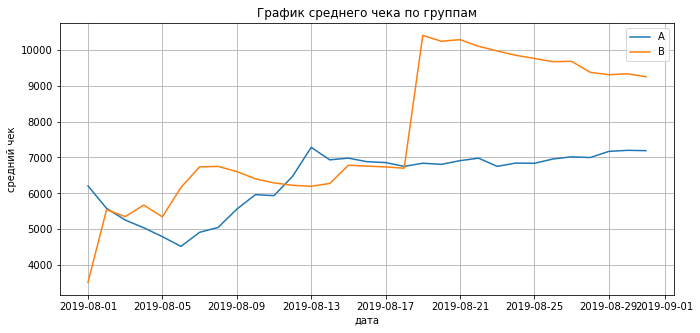

In [30]:
plt.figure(figsize=(11,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.xlabel('дата')
plt.ylabel('средний чек')
plt.title('График среднего чека по группам')
plt.grid()

plt.legend();

Средний чек в группах очень неравномерен. Выравнивание идет только c середины теста (со второй половины августа), после резкого скачка показателя группы B в августе.
Практически на протяжении всего теста средний чек группы B был выше. Возможно, в эту группу попали дорогостоящие товары, которые создают всплеск на графике. Таким образом, для установление нормального среднего группе B необходимо больше данных.

### 3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A <a id="3.3id"></a>

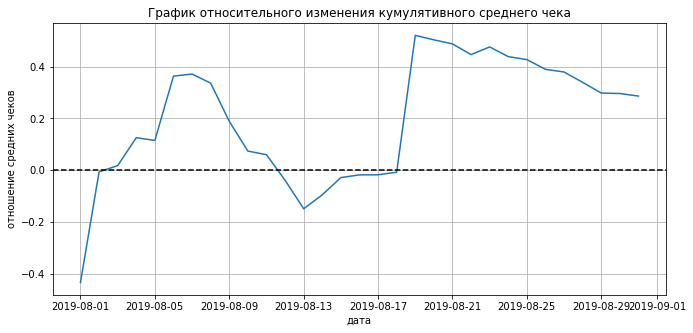

In [31]:
plt.figure(figsize=(11,5))

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.xlabel('дата')
plt.ylabel('отношение средних чеков')
plt.title('График относительного изменения кумулятивного среднего чека')
plt.grid()

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

График отношения средних чеков достаточно резко меняется. Необходимо анализировать выбросы, которые покажут крупные заказы в той и другой группе.

### 4. Построим график кумулятивной конверсии по группам <a id="3.4id"></a>

In [32]:
# найдем максимальное и минимальное значения оси x
orders['date'].describe()

count                    1016
unique                     31
top       2019-08-05 00:00:00
freq                       43
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

In [33]:
# считаем кумулятивную конверсию и ее максимальное и минимальное значения
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
print(round(cumulativeData['conversion'].max(), 3))
print(round(cumulativeData['conversion'].min(), 3))

0.036
0.024


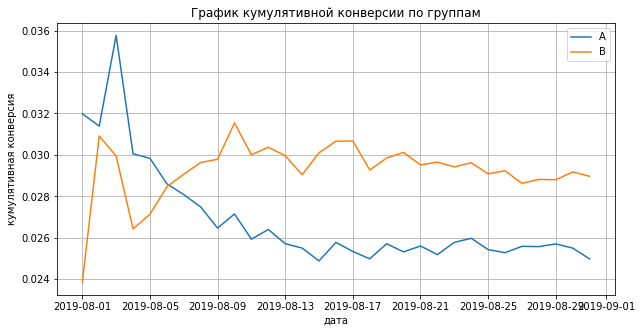

In [34]:
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(10,5))
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('дата')
plt.ylabel('кумулятивная конверсия')

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.grid()

# задаем масштаб осей
#plt.axis(['2019-08-01', '2019-08-31', 0.020, 0.040]);

Вначале показатель в группе A был выше. После - конверсия группы B стала выше и зафиксировалась на этом месте относительно группы B до конца теста. Конверсия группы A просела и так же зафиксировалась.
Вероятно, после достижения достаточной статистической мощности результат выравнялся

### 5. Построим график относительного изменения кумулятивной конверсии группы B к группе A <a id="3.5id"></a>

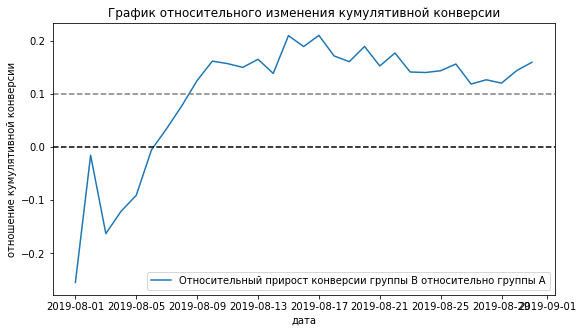

In [35]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(9,5))
plt.title('График относительного изменения кумулятивной конверсии')
plt.xlabel('дата')
plt.ylabel('отношение кумулятивной конверсии')

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
#plt.axis(["2019-08-01", '2019-08-31', -0.3, 0.3]);

Вначале теста конверсия группы B проигравала группе A. После вырвалась вперед. К концу периода обе конверсии имеют тенденцию к снижению. Однако показатель группы A снижается чуть активнее, что увеличивает отношение показателя группы B к A.
Конверсия - это отношение числа заказов к количеству посетителей за время теста. Пользователи, совершившие много заказов, могут сильно влиять на показатель конверсии.
Попроуем с помощью анализа аномалий проверить эту гипотезу.

### 6. Построим точечный график количества заказов по пользователям <a id="3.6id"></a>

Подсчитаем количество заказов по пользователям

In [36]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['visitorId', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitorId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


Есть пользователи, которые совершали 2 и 3 заказа, что больше, чем совершает в среднем посетитель сайта за неделю (всего один, гистограмма ниже).

Построим гистрограмму распределения количества заказов на одного пользователя:

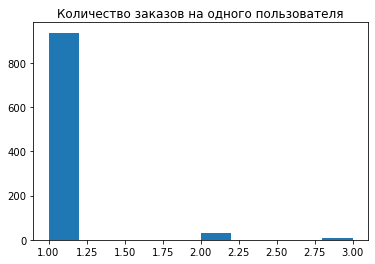

In [37]:
plt.hist(ordersByUsers['orders'])
plt.title('Количество заказов на одного пользователя');

Большинство совершают только один заказ. Но есть доля и тех, кто делает 2-3 заказа. Распределение ненормальное.

Построим точечную диаграмму числа заказов на одного пользователя:

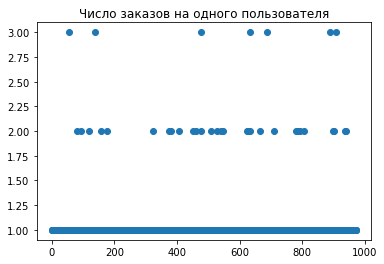

In [38]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Число заказов на одного пользователя'); 

Достаточно много пользователей, которые делают 2-3 заказа. Однако их доля неясна, чтобы можно было их определить, как аномальные.

### 7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей <a id="3.7id"></a>

Посчитаем выборочные перцентили количества заказов на одного пользователя:

In [39]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[1. 2.]


Не более 5% пользователей оформляли более одного заказа. Не более 1% оформляли более двух заказов. Так как по графику из предыдущего пункта видно, что есть значительно число пользователей, совершающих более одного заказа, то отсечем только 1% в качестве аномальных значений.

In [40]:
max_orders = int(np.percentile(ordersByUsers['orders'], [99]))
max_orders

2

### 8. Построим точечный график стоимостей заказов <a id="3.8id"></a>

Для начала построим гистограмму распределения стоимостей заказов: 

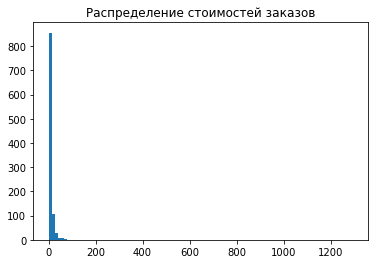

In [41]:
plt.hist(orders['revenue']/1000, bins=100)
plt.title('Распределение стоимостей заказов');

По гистограмме видно, что большинство заказов умещается в диапазон до 100 тыс рублей.

Построим точечный график распределения:

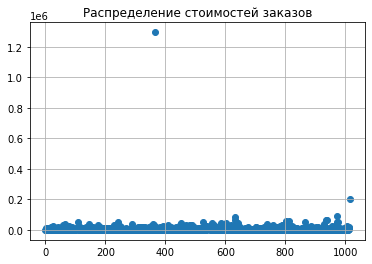

In [42]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.grid()
plt.title('Распределение стоимостей заказов'); 

Большинство посетителей приобретают товары на сумму не более 100 тыс рублей. Видим два выброса: один в районе 200 тыс рублей, второй - очень крупный, более 1.2 млн рублей.
Взглянем на график чуть ближе:

In [43]:
orders_query = orders.loc[orders['revenue'] < 180000]
x2_values = pd.Series(range(0,len(orders_query['revenue'])))

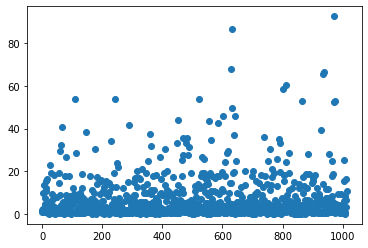

In [44]:
plt.scatter(x2_values, orders_query['revenue']/1000);

Большая концентрация покупателей расположена в диапазоне до 20 тыс рублей. Просчитаем перцентили, чтобы понять, какую долю занимают заказы более 20 тыс.

### 9. Посчитаем 95-й и 99-й перцентили стоимости заказов <a id="3.9id"></a>

In [45]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


Не более 5% заказов дороже 26 785 рублей и не более 1% дороже 53 904 рубля.
5% заказов все же кажется значительным объемом для того, чтобы исключить его из выборки. Установим 99-перцентиль, как границу для определения аномальных значений.

### 10. Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным <a id="3.10id"></a>

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы:

- `HO:` различий в конверсии между группами нет;
- `H1:` различия в конверсии между группами есть.

Уровень статистической значимости - 0.05

Подготовим данные

In [46]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']


visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

Посчитаем статистическую значимость различия в конверсии между группами.
Создадим переменные `ordersByUsersA` и `ordersByUsersB` со столбцами ['visitorId', 'transactionId']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Таким образом подготовим выборки к проверке критерием Манна-Уитни.

Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.
Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1. Округлим до трёх знаков после запятой.

In [47]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value:',"{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Различие в конверсии:',"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.01102
Различие в конверсии: 0.160


p-value получился меньше 0.05. Значит нулевую гипотезу о том, что различий в конверсии между группами нет отвергаем. Относительный выигрыш группы B относительно группы A равен 16%.

### 11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным <a id="3.11id"></a>

- `H0:` различий в среднем чеке между группами нет;
- `H1:` различия в среднем чеке между группами есть

Передадим критерию mannwhitneyu() данные о выручке с заказов, а также найдём относительные различия в среднем чеке между группами:

In [48]:
print('p-value: {0:.5f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Различие в среднем чеке: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value: 0.82949
Различие в среднем чеке: 0.287


p-value сильно больше статистической значимости в 0.05. Не отвергаем нулевую гипотезу о том, что различий в среднем чеке между группами нет. По сырым данным выигрыш группы B составляет почти 29% по отношению к группе A. 
Нами были замечаны аномальные значения. Возможно, их обработка позволит изменить результат теста.

Примем за аномальных пользователей тех, кто совершил более 2 заказов или совершил заказ дороже 53 904 рублей. Таким образом мы уберем 1% посетителей с наибольшим числом заказов и 1% пользователей с дорогими заказами.

Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 53 904 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers

In [49]:
revenu_max=np.percentile(orders['revenue'], [95, 99])[1]
revenu_max

53904.0

In [50]:
# вычисление количества аномальных пользователей

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > max_orders]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > max_orders]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > revenu_max]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
Name: visitorId, dtype: int64
16


Итого 16 аномальных пользователей.

### 12. Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным <a id="3.12id"></a>

Выясним, как эти пользователи повлияли на результаты теста.

Сформулируем гипотезы:

- `HO:` различий в конверсии между группами нет;
- `H1:` различия в конверсии между группами есть.

In [51]:
# подготовка выборки количества заказов по пользователям по группам теста

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [52]:
print('p-value: {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Различие в конверсии: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value: 0.00702
Различие в конверсии: 0.189


p-value намного меньше 0.05. Отвергаем нулевую гипотезу об отсутствии различий показателей конверсии. После обработки аномальных значений конверсия группы B увеличилась до 18,9% относительно конверсии группы A.

### 13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным <a id="3.13id"></a>

- `H0:` различий в среднем чеке между группами нет;
- `H1:` различия в среднем чеке между группами есть

In [53]:
print(
    'p-value:{0:.5f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Различие в среднем чеке: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

p-value:0.78770
Различие в среднем чеке: -0.032


p-value больше 0.05. Нулевую гипотезу о равенстве средних чеков отвергнуть не можем.
Относительное изменение среднего чека в группе B по отношению группы A после очистки данных -3.2%. Таким образом, средий чек после фильтрации аномалий (убрали крупный заказ на 1.2 млн руб) у группы B снизился и стал меньше среднего чека группы A.

### 14. Решение по результатам теста <a id="4id"></a>

**Результаты:**

- обнаружены статистически значимые различия по конверсии между группами по «сырым» и по данным после обратботки аномальных значений. 16% по сырым и 19% по очищенным данным показатели группы B были выше A, что говорит об увеличении количества покупателей;
- разница между сегментами по среднему чеку группы B к группе А по очищенным данным сократилась с 29% в пользу группы B до 3% в пользу группы A. Не смотря на это из-за значительного увеличения числа покупателей в группе B прибыль компании все равно увеличится;
- разница показателей конверсии является статистически значимой, поэтому есть смысл останосить тест, признать его успешным (победу группы B) и применить изменение, которое мы проверяли на статистическую значимость, на всех посетителей.

## 5. Выводы <a id="5id"></a>

Целью данного исследования является получение данных, на основе которых интернет-магазин может увеличить свою выручку.

В распоряжении у нас было три файла с информацией:
- файл с девятью гипотезами;
- таблица с заказами пользователей;
- таблица посетителей, разделенных на две группы

Перед запуском A/B-теста была проведена приоритезация гипотез с помощью фреймворков ICE и RICE. Лидирующими на проведение теста оказались:
- `добавление формы подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`;
- `добавление двух новых каналов привлечения трафика, что позволит привлекать на 30% больше пользователей`

В ходе проведения A/B-теста проверялись две метрики: изменение конверсии и размера среднего чека в обеих группах. Анализ производился, как на "сырых", так и на очищенных данных, чтобы определить силу влияния выбросов.

Различия конверсии по сырым и очищенным данным тест не показал. В обоих случаях лидировала группа B. Обработка аномалий повлияла на показатель среднего чека. С выбросами средний чек группы B был выше на 29%. После обработки стал ниже среднего чека группы A на 3,2%.
С учетом большого увеличения "покупающих" пользователей группы B выручка все равно увеличилась.

Принято решение остановить тест и признать его успешным. Распространить нововведение на всех пользователей интернет-магазина.